In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm

from scipy.optimize import minimize
from scipy.stats import norm

import warnings
warnings.simplefilter('ignore')

In [2]:
class GPOptimizer:
    def __init__(self, target_func, x_range,
                 kernel='ExpQuad', init_points=3, render=True):
        '''
        x's should be continuous
        '''
        
        self.target_func = target_func
        self.cov_func = kernel
        
        self.x_min = np.array(x_range[0]).reshape(-1,)
        self.x_max = np.array(x_range[1]).reshape(-1,)
        self.x_mid = 0.5 * self.x_min + 0.5 * self.x_max
        self.x = np.vstack((self.x_min, self.x_mid, self.x_max))
        self.dim = self.x_min.size
        
        
        for i in range(max(init_points - 3, 0)):
            x_sample = []
            for d in range(self.dim):
                a = np.random.rand()
                x_sample.append(a * self.x_min[d] * (1 - a) * self.x_max[d])
            x_sample = np.array(x_sample).reshape(1, -1)
            self.x = np.vstack((self.x, x_sample))
            
        print('Initial x:')
        print(self.x)
        
        self.y = np.array([target_func(x_i) for x_i in self.x]).reshape(-1,)
        self.prior = {
            'nu': 1, 'theta0': 1, 'theta': 1,
            'alpha': 1, 'beta': 1, 'alpha0': 1, 'beta0': 1
        }
        
        self.render = render
        
    def sample(self, mode='opt', acq_func='ei'):
        print('\n' + '-' * 50 + '\n')
        
        with pm.Model() as model:
            theta = pm.Gamma(
                'theta', 
                alpha=self.prior['alpha'], beta=self.prior['beta'],
                shape=(self.dim,)
            )
            theta0 = pm.Gamma(
                'theta0',
                alpha=self.prior['alpha0'], beta=self.prior['beta']
            )
            
            if self.cov_func == 'ExpQuad':
                cov_func = theta0 ** 2 * pm.gp.cov.ExpQuad(input_dim=self.dim, ls=theta)
            elif self.cov_func == 'Matern52':
                cov_func = theta0 ** 2 * pm.gp.cov.Matern52(input_dim=self.dim, ls=theta)
            else:
                raise ValueError('Covariance function not set')
                
            m = pm.gp.mean.Constant(self.y.mean())
            gp = pm.gp.Marginal(m, cov_func)
            nu = pm.HalfCauchy('nu', self.prior['nu'])  # noise
            gp.marginal_likelihood('f', X=self.x, y=self.y, noise=nu)
            
            if mode == 'mcmc':
                trace = pm.sample(1000, chains=1)
                
                x_next_ls = []
                for t in trace[::250]:  # thinning the samples
                    x_next_ls.append(self.get_next(params=t, acq_func=acq_func, gp=gp))
                x_next = np.array(x_next_ls).mean(axis=0)
            
            elif mode == 'opt':
                map_ = pm.find_MAP()
                x_next = self.get_next(params=map_, acq_func=acq_func, gp=gp)
                
            return x_next
        
    def get_next(self, params, acq_func, gp):
        def acq(x_star):
            x_star = np.array(x_star).reshape(1, -1)
            mean, var = gp.predict(x_star, point=params, diag=True, pred_noise=False)
            mean = mean[0]
            std = np.sqrt(var[0])
            
            if acq_func == 'ei':
                f_best = self.y.min()
                gamma = (- f_best + mean) / std
                
                return std * (norm.cdf(gamma) * gamma + norm.pdf(gamma))
            
            elif acq_func == 'pi':
                f_best = self.y.min()
                gamma = (- f_best + mean) / std
                
                return norm.cdf(gamma)
            
            elif acq_func == 'lcb':
                return mean - 2 * std
        
        bounds = [(low, high) for low, high in zip(self.x_min, self.x_max)]
        result = minimize(acq, x0=self.x_mid, bounds=bounds)
        x_next = result.x
        
        if self.render:
            self.visualize(self.target_func, x_next)
        
        return x_next
    
    def optimize(self, x_exist=None, y_exist=None, 
                 mode='opt', acq_func='ei', max_iter=10):
        if x_exist is not None and y_exist is not None:
            self.x = x_exist
            self.y = y_exist
            
        for i in range(max_iter):
            x_next = self.sample(acq_func=acq_func, mode=mode)
            if x_next in self.x:
                break
            
            y_next = self.target_func(x_next)
            
            self.x = np.vstack((self.x, x_next))
            self.y = np.hstack((self.y, y_next))
        
        x_star_id = np.argmin(self.y)
        return self.x[x_star_id], self.y[x_star_id]
    
    def visualize(self, func, point):
        x = np.linspace(self.x_min, self.x_max, 50)
        y = func(x)
        
        plt.plot(x, y, c='k', label='True function')
        plt.scatter(
            self.x, self.y, 
            marker='o', s=10, color='blue', label='Current dataset'
        )
        plt.plot([point], [func(point)], marker='o', color='red', label='Next query')
        
        plt.xlim(self.x_min, self.x_max)
        plt.legend()
        plt.show()

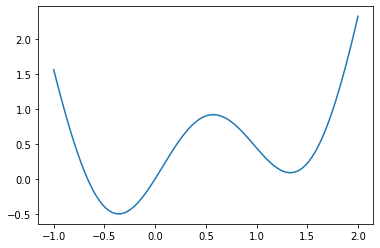

In [3]:
def f(x):
    return np.sin(3 * x) + x ** 2 - 0.7 * x

xs = np.linspace(-1, 2, 100)
plt.plot(xs, f(xs))
plt.show()

Initial x:
[[-1.        ]
 [ 0.5       ]
 [ 2.        ]
 [-0.3896017 ]
 [-0.41838831]]

--------------------------------------------------



logp = -6.4112, ||grad|| = 0.00028915: 100%|██████████| 38/38 [00:00<00:00, 1106.28it/s]  


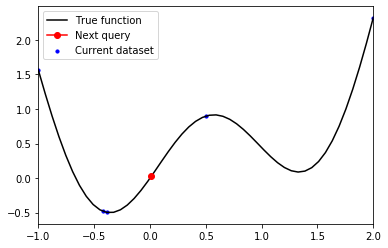


--------------------------------------------------



logp = -6.8459, ||grad|| = 0.43781: 100%|██████████| 40/40 [00:00<00:00, 891.54it/s]    


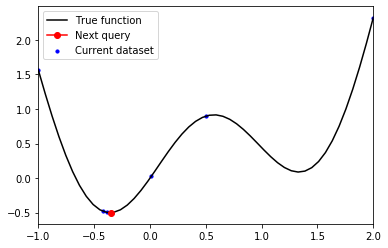


--------------------------------------------------



logp = -1.6887, ||grad|| = 0.012708: 100%|██████████| 36/36 [00:00<00:00, 891.48it/s]  


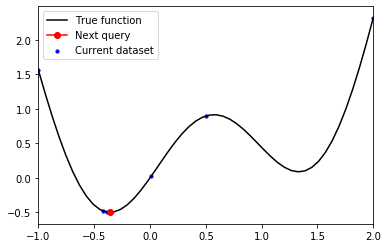


--------------------------------------------------



logp = 11.137, ||grad|| = 0.084717: 100%|██████████| 37/37 [00:00<00:00, 1176.84it/s]  


KeyboardInterrupt: 

In [4]:
optimizer = GPOptimizer(target_func=f, x_range=[-1, 2], init_points=5)

optimizer.optimize(mode='opt', acq_func='lcb', max_iter=5)

In [ ]:
optimizer = GPOptimizer(target_func=f, x_range=[-1, 2], init_points=5)

optimizer.optimize(mode='opt', acq_func='ei', max_iter=5)

In [ ]:
optimizer = GPOptimizer(target_func=f, x_range=[-1, 2], init_points=5)

optimizer.optimize(mode='opt', acq_func='poi', max_iter=5)